# Scientific Computing Report

This report will outline the code produced for this module as a library able to compute limit cycles of ODE's and PDE's as well as confirming the steady-states of diffusive PDE's

# A brief summary of your software (30% of the marks)

Structure of the modules,
How inputs are taken,
Checks,
Outputs

Start with the ODE solvers:

1. Present the difference between the solvers for solving a few steps of ODE of n dim
2. Isolate a periodic solution using shooting and know parameters
3. Trace out the parameter-period curve using both natural and pseudo-arclength continuation methods.


In [1]:
# imports 
import numpy as np
import matplotlib.pyplot as plt
from helpers import *

## ODE solvers

### solve_to and solvers.py
These methods are used as the building blocks for all the other integration code

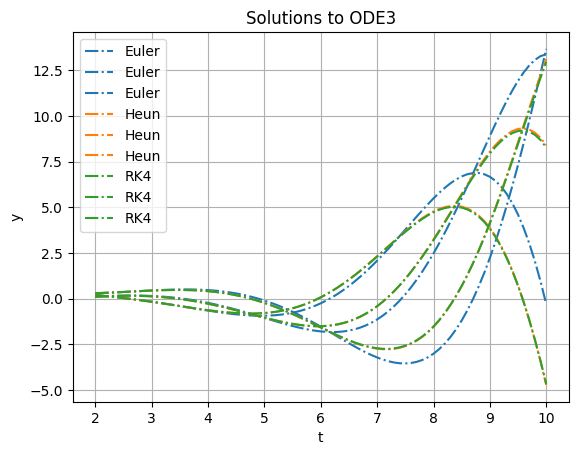

In [2]:
from solve_to import solve_to
from test_equations import ode3

# define the initial conditions
y0, t0, t1, delta_t = [0.3, 0.1, 0.2], 2, 10, 0.1 

# solve the ODE
for i, method in enumerate(['Euler', 'Heun', 'RK4']):
    Y, t = solve_to(ode3, y0, t0, t1, delta_t, method)
    # plot the solution
    plt.plot(t, Y, label=method, color='C'+str(i), linestyle='-.')

plot_help(plt, 't', 'y', 'Solutions to ODE3', legend=True)

The solvers (solvers.py) that I have implemented are single step integrators using the Euler, RK4 and Heun method. These methods provide different accuracies (with Heul and RK4 being much more accurate than Euler). The functions are incorporated in the solve_to method which allows the integration of a function between 2 times. The functions take any number of dimensions as long as the function is provided in a first order form. The plot above shows a 3 dimensional ODE solved by all three methods.

### Discretisation, shooting_setup, shooting_solve
These methods are made in such a way that the Discretisation class will provide a discretisation of a given problem (either [currently] using a shooting method or a linear [none] method). This class is made so that adding other discretisations is simple and the outputs and inputs are always the same. This is build on using the continuation class.

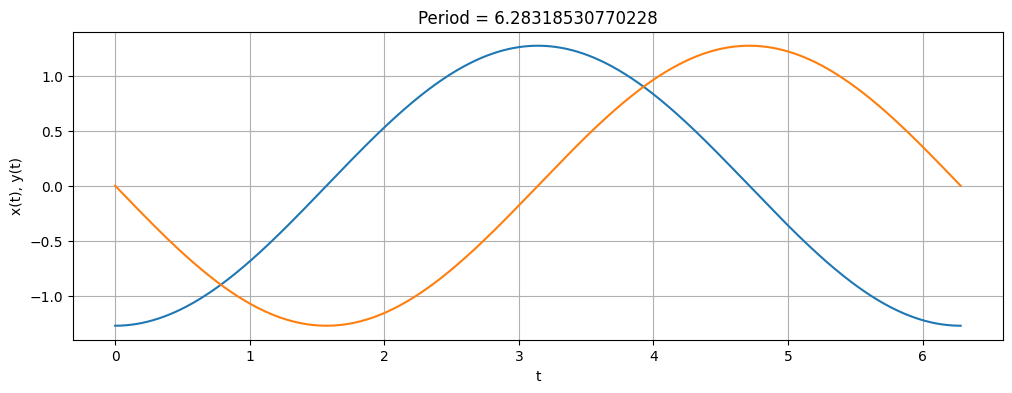

In [17]:
from shooting import Discretisation, shooting_solve
from test_equations import hopf

discret = Discretisation() # create the discretisation object
# initial guess
Y0, T, b = [0.1,0.1], 10, 1
u0 = np.append(Y0, T)

# solve the ode using the shooting method - here the discretisation is using shooting
fun = discret.shooting_setup(hopf, Y0, T=T, args=b)
Y0, T0 = shooting_solve(fun, u0)

# solve for one period of the solution
Y,t = solve_to(hopf, Y0, 0, T0, args=b)
plt.figure(figsize=(12,4))
plt.plot(t, Y)
plot_help(plt, 't', 'x(t), y(t)', 'Period = ' + str(T0))

The discretisation using shooting (or linear method) are then used by the Continuation class. The continuation class contains the natural continuation method where for any given equation, starting point and parameters, the method aims to find the root of the discretised problem (whether its a root of an equation or a shooting problem identifying the limit cycle) at each parameter value and then incrementing the parameter to follow the solution.

All the continuation methods will take as input: function, x0, starting param, vary param (idx), step, max_steps, discretisation type. The Continuation class allows for simple inclusion of other methods - such at the pseudo-arclength continuation method. The discretisation used to make the function F(u) = 0 to be solved is modular and so can be accessed for other methods once they are developed.

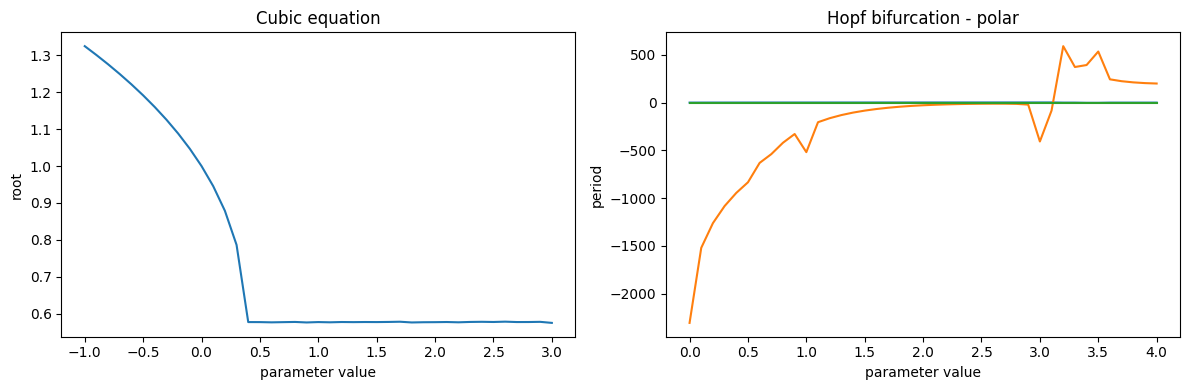

In [4]:
from continuation import Continuation
import scipy.optimize
from test_equations import cubic, hopf_polar

# create continuation class
cont = Continuation(solver=scipy.optimize.root)
# create discretisation class
discret = Discretisation()
x0 , p0 = 1, -1
# solve for the root of the cubic equation using no discretisation
X, C = cont.nat_continuation(cubic, x0, p0, vary_p=0, step=0.1, max_steps=40, discret=None)
# plot the solution
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(C, X)
ax[0].set_xlabel('parameter value')
ax[0].set_ylabel('root')
ax[0].set_title('Cubic equation')

# now need to test natural continuation with a differential equation - Hopf bifurcation and shooting discretisation
discret = Discretisation().shooting_setup
x0 , p0 = [1, 1,1], [0, 1]
# solve for the root of the hopf equation using shooting discretisation
X, C = cont.nat_continuation(hopf_polar, x0, p0, step=0.1, max_steps=40, discret=discret)
# plot the solution
ax[1].plot(C, X)
ax[1].set_xlabel('parameter value')
ax[1].set_ylabel('period')
ax[1].set_title('Hopf bifurcation - polar')
fig.tight_layout()

The continuation above shows the performance of the natural continuation method for both a simple algebraic equation and an ODE


## PDE solvers 

Solver profiling and showing modularity
1. BVP solver
2. PDE solver
- Explicit methods
- Implicit methods

1. The bvp_solver contains the ODE object and the Solver class. The ODE object stores all the coefficients, boundary conditions, functions and arguments associated with an ODE equation in 2nd order form. The Solver class allows the equation, number of interior points and the solving method to be specified and the problem initialised. The solver then solves problem giving the solution values u = solver.solve() (implementing the method defined earlier). The solver object stores the solutions u and the grid x. These modules allow for a source term to be included (as a function of x,u and args).

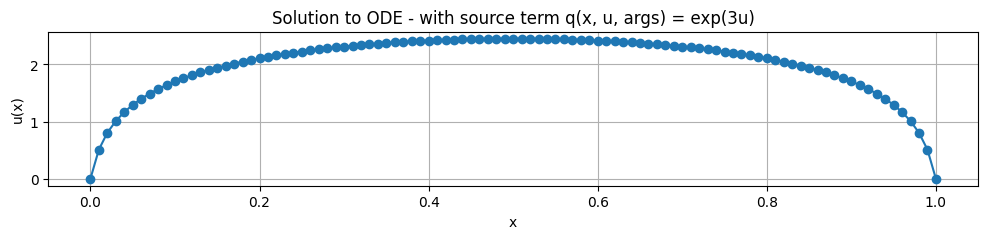

In [19]:
# define the BVP ODE to solve
m, c, k,  bound_type, alpha, beta, a, b, args = 1, 1, 1, 'DD', 0, 0, 0, 1, (3,)
q = lambda x, u, *args: np.exp(args[0] * u) # lambda function for q(x, u, args)

# create the ODE object
from bvp_solver import ODE
ode = ODE(m, c, k, q, bound_type, alpha, beta, a, b, *args)
# create the solver object
from bvp_solver import Solver
N , method = 100, 'scipy'
solver = Solver(ode, N, method)
# solve the ODE
u = solver.solve()
x = solver.x

plt.figure(figsize=(12,2))
# plot the solution
plt.plot(x, u, 'o-')
plot_help(plt, 'x', 'u(x)', 'Solution to ODE - with source term q(x, u, args) = exp(3u)')


2. PDE solver:
The pde_solver module functions in the same way as the ode_solver module. The PDE object contains the same all the coefficients, boundary conditions, functions (starting condition and source term) and arguments associated with an PDE equation in 2nd order form. The main difference is that there are different methods allowed to be specified in the Solver class and that the source function can be non-linear and a function of (x, t, u, args).

In [6]:
# demo of some of the PDE solvers - most complicated versions
from pde_solver import PDE, Solver

# make the PDE object
f, m, q, bound_type, alpha, beta, a, b, args = lambda x: np.sin((np.pi*(x-a)/b-a)),1,1,'DD', 0, 0, 0, 1, (3,) # linear source term
pde = PDE(f, m, q, bound_type, alpha, beta, a, b, *args)
q = lambda x, t, u, *args: np.exp(args[0] * u ) # lambda function for q(x, u, args) - non linear source term
hard_pde = PDE(f, m, q, bound_type, alpha, beta, a, b, *args)

# create the solver object with a variety of methods
solver = Solver(pde, N=20, t_final=1, method='solve_ivp')

Solving using solve_ivp
Shapes u, x, t: (21, 481), (21,), (481,)


Text(0.5, 0.92, 'Solution to PDE - q(x, t, u) = 1 - solve_ivp')

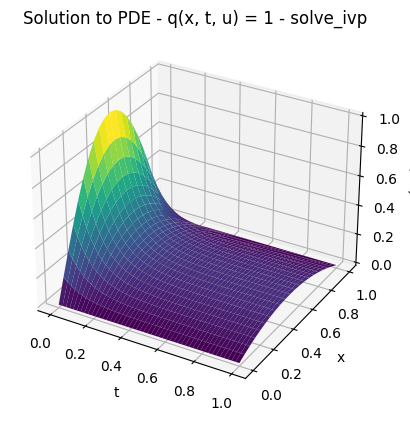

In [7]:
# solve the first simple PDE
u = solver.solve()
x = solver.x
t = solver.t
print('Shapes u, x, t: '+ str(u.shape) + ', ' + str(x.shape) + ', ' + str(t.shape))

# plot the solution as a surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
T, X = np.meshgrid(t, x)
ax.plot_surface(T, X, u, cmap='viridis')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('u(x,t)')
ax.set_title('Solution to PDE - q(x, t, u) = 1 - solve_ivp')

Solving using the RK4 method


/var/folders/4d/1cd5pk9s6f7_prxws19jm1fw0000gn/T/ipykernel_98032/3939900161.py:8: RuntimeWarning: overflow encountered in exp
  q = lambda x, t, u, *args: np.exp(args[0] * u ) # lambda function for q(x, u, args)
/Users/philblecher/Desktop/Github/ScientificComputing-EMAT30008/pde_solver.py:343: RuntimeWarning: invalid value encountered in matmul
  return (D / self.dx**2) * (A_ @ u + b_) + qval


Shapes u, x, t: (201, 81634), (201,), (81634,)


Text(0.5, 0.92, 'Solution to PDE - q(x, t, u) = exp(3u) - RK4')

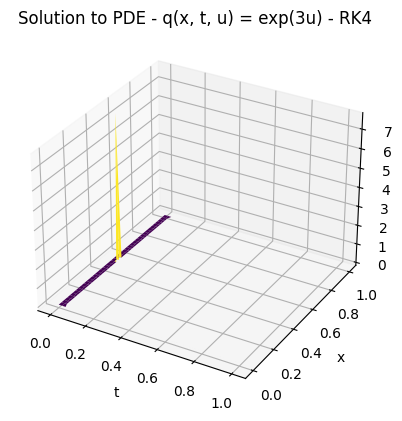

In [8]:
# solve the second more complicated PDE using homemade RK4
hard_solver = Solver(hard_pde, N=200, t_final=1, method='RK4', CFL=0.49)
u = hard_solver.solve()
x = hard_solver.x
t = np.append(hard_solver.t, hard_solver.t_final)
print('Shapes u, x, t: '+ str(u.shape) + ', ' + str(x.shape) + ', ' + str(t.shape))

# plot the solution as a surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
T, X = np.meshgrid(t, x)
ax.plot_surface(T, X, u, cmap='viridis')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('u(x,t)')
ax.set_title('Solution to PDE - q(x, t, u) = exp(3u) - RK4')



In [9]:
# profiling of the solvers (for the equation in the previous cell)
from pde_solver import profile
stats, methods = profile(pde, N=50, t_final=1)

Solving using the Euler method
Solving using the RK4 method
Solving using the Heun method
Solving using the implicit Euler method
Solving using the Crank-Nicolson method
Solving using the IMEX Euler method


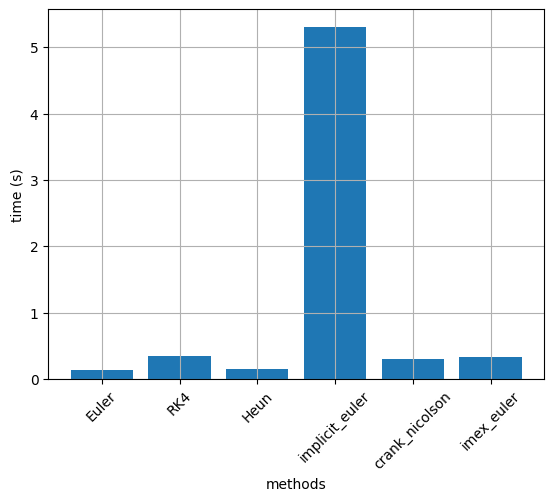

In [10]:
# for each stats object, extract the total time and plot as a bar chart
total_tt = []
num_calls = []
for i, method in enumerate(methods):

    stats[i].strip_dirs()
    total_tt.append(stats[i].get_stats_profile().total_tt)

plt.figure()
plt.bar(methods, total_tt)
plt.xticks(rotation=45)
plot_help(plt, 'methods', 'time (s)')



In [11]:
# why is implicit euler so slow?
print(stats[3].sort_stats('calls').print_stats(10))

         1005369 function calls (1005367 primitive calls) in 5.304 seconds

   Ordered by: call count
   List reduced from 67 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   275564    0.033    0.000    0.033    0.000 {built-in method builtins.callable}
   270461    0.556    0.000    3.627    0.000 pde_solver.py:215(F_solve)
   270461    3.039    0.000    3.071    0.000 pde_solver.py:194(F)
15318/15316    0.014    0.000    0.041    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    15309    0.009    0.000    0.009    0.000 {built-in method builtins.issubclass}
    10209    0.003    0.000    0.003    0.000 {built-in method builtins.isinstance}
    10208    0.003    0.000    0.003    0.000 {built-in method builtins.len}
    10206    0.013    0.000    0.021    0.000 numerictypes.py:282(issubclass_)
    10206    0.002    0.000    0.002    0.000 fromnumeric.py:1987(_shape_dispatcher)
    10206    0.005  

how can i improve that?

Solving using the Crank-Nicolson method
Solving using the Crank-Nicolson method
Solving using the Crank-Nicolson method
Solving using the Crank-Nicolson method


KeyboardInterrupt: 

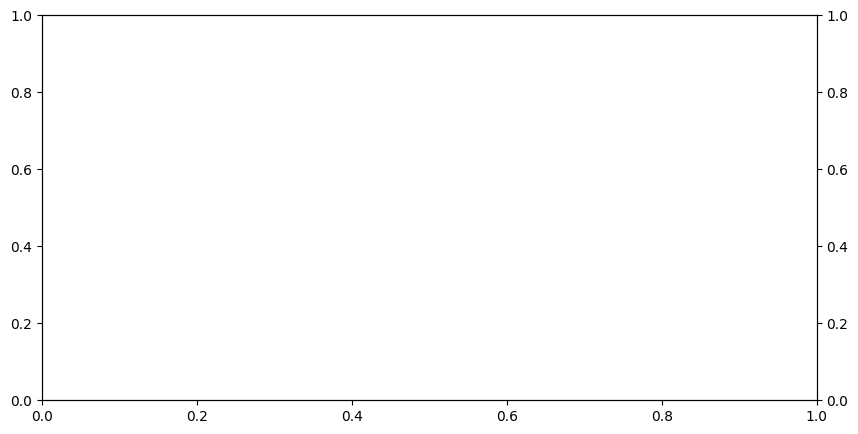

In [13]:
from helpers import help_prof

# one axis for time, one for memory on the same plot and corresponding colours
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax2 = ax.twinx()
for i,sparse in enumerate([True, False]):
    total_t = []
    stor = []
    n_range = np.linspace(10, 1000, 10, dtype=int)
    for n in n_range:
        stats, nbytes = help_prof(n, sparse, Solver, pde) # help_prof profiles the solver returns stats and memory usage
        total_t.append(stats.get_stats_profile().total_tt)
        stor.append(nbytes)
    ax.plot(n_range, total_t, label='time (sparse = %s)' %str(sparse), color='C'+str(i+2))
    ax2.plot(n_range, stor, color='C'+str(i+2), linestyle='--', label='memory (sparse = %s)'% str(sparse))
ax.set_xlabel('N - grid points')
ax.set_ylabel('total time (s)')
ax2.set_ylabel('A_mat size - memory (bytes)')
ax.tick_params(axis='y', colors='C2')
ax2.tick_params(axis='y', colors='C3')
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.85))
plt.show()


# A description of the key software design decisions made (40% of the marks)

Structure

# A reflective learning log (30% of the marks)